In [1]:
from __future__ import print_function

In [2]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    'ZERO': 0,
    'ONE': 1,
    'TWO': 2,
    'THREE': 3,
    'FOUR': 4,
    'FIVE': 5,
    'SIX': 6,
    'SEVEN': 7,
    'EIGHT': 8,
    'NINE': 9
}
show_summary = True
show_dataset_analyze = False

In [3]:
# Load Network and Print Summary
from mnist.utils import get_device

# Check GPU availability
use_cuda, device = get_device()

In [4]:
from mnist.dataset import get_loader
from mnist.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

In [5]:
## Calculate Class Scale
from mnist.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader)

In [6]:
import time
import math

from mnist.model import Net
from mnist.backpropagation import train, test, get_sgd_optimizer
from mnist.utils import initialize_weights, print_modal_summary
from mnist.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from mnist.training import Training

# Train Params
epochs = 20
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
lambda_l1 = 1e-7
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)

trainers = []

for t in ['bn_l1', 'gn', 'ln']:
    norm='bn'
    ctrain = train()
    
    if t == 'bn_l1':
        ctrain = train(use_l1=True, lambda_l1=lambda_l1)
    elif t == 'gn':
        norm = 'gn'
    elif t == 'ln':
        norm = 'ln'
    
    model = Net(norm=norm).apply(initialize_weights).to(device)
    optimizer = get_sgd_optimizer(model, lr=lr)

    # Pytorch one cycle scheduler
    pytorch_scheduler = one_cycle_lr_pt(
        optimizer, 
        lr=lr, 
        max_lr=max_lr, 
        steps_per_epoch=steps_per_epoch, 
        epochs=epochs, 
        anneal_strategy='linear'
    )

    # One cycle schedule with custome function
    custom_scheduler = one_cycle_lr_custom(
        optimizer, 
        lr=lr, 
        max_lr=max_lr, 
        steps_per_epoch=steps_per_epoch, 
        epochs=epochs, 
        anneal_strategy='linear'
    )

    trainer = Training(
        model,
        optimizer,
        custom_scheduler,
        ctrain,
        test,
        train_loader,
        test_loader,
        lr,
        epochs,
        device,
        dropout
    )

    trainers.append(trainer)

for trainer in trainers:
    if show_summary:
        print_modal_summary(trainer.model)
    trainer.run()

Using Device: cuda
Epochs: 20
Lr: 0.05
Max Lr: 0.1
Batch Size: 32
Dropout: True
--------------------------------------------------------
| Name                     	Shape          	Params |
--------------------------------------------------------
| block1.conv1.weight      	[4, 1, 3, 3]   	    36 |
| block1.conv1.bias        	[4]            	     4 |
| block1.n1.weight         	[4]            	     4 |
| block1.n1.bias           	[4]            	     4 |
| block1.conv2.weight      	[4, 4, 3, 3]   	   144 |
| block1.conv2.bias        	[4]            	     4 |
| block1.n2.weight         	[4]            	     4 |
| block1.n2.bias           	[4]            	     4 |
| block1.conv3.weight      	[4, 4, 3, 3]   	   144 |
| block1.conv3.bias        	[4]            	     4 |
| block1.n3.weight         	[4]            	     4 |
| block1.n3.bias           	[4]            	     4 |
| block2.conv1.weight      	[8, 4, 3, 3]   	   288 |
| block2.conv1.bias        	[8]            	     8 |
| block2.n1

## Analyze Network

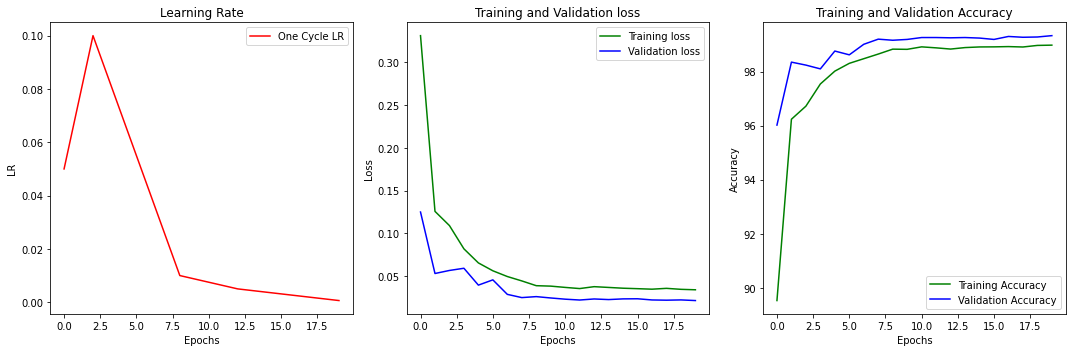

Total Incorrect Predictions 67


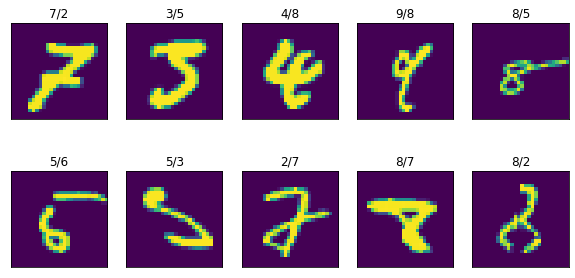

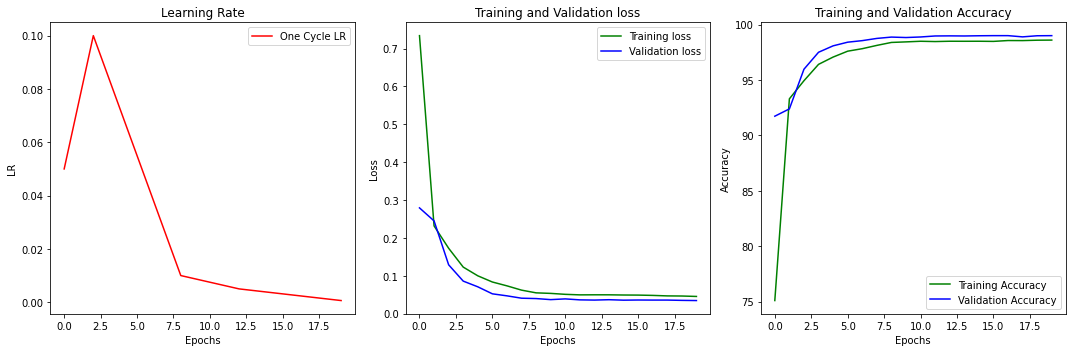

Total Incorrect Predictions 100


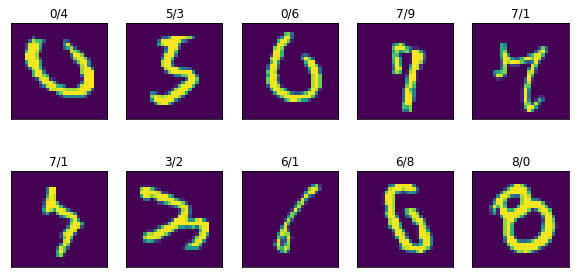

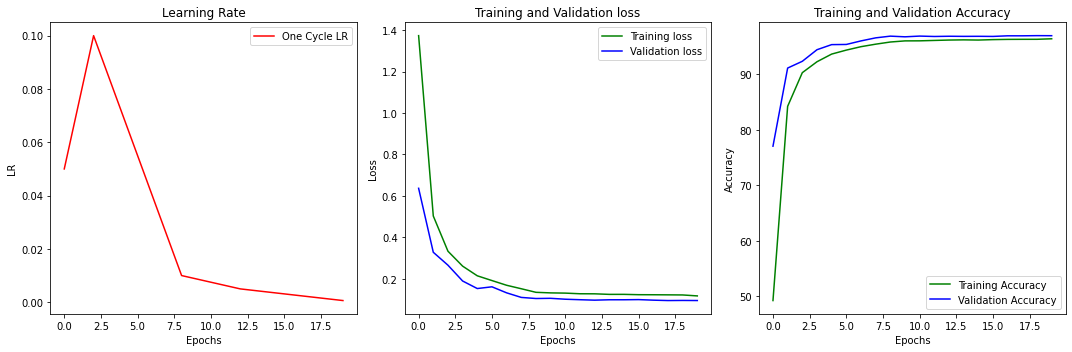

Total Incorrect Predictions 300


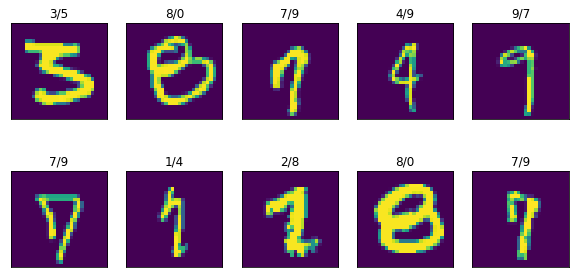

In [7]:
from mnist.visualize import plot_network_performance
from mnist.utils import get_incorrrect_predictions
from mnist.visualize import plot_incorrect_predictions

from mnist.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from mnist.visualize import plot_confusion_matrix

for trainer in trainers:
#     trainer.print_best_model()
    plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

#     all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
#     confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
#     plot_confusion_matrix(confusion_matrix, class_map, False)

    incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
    plot_incorrect_predictions(incorrect, class_map)

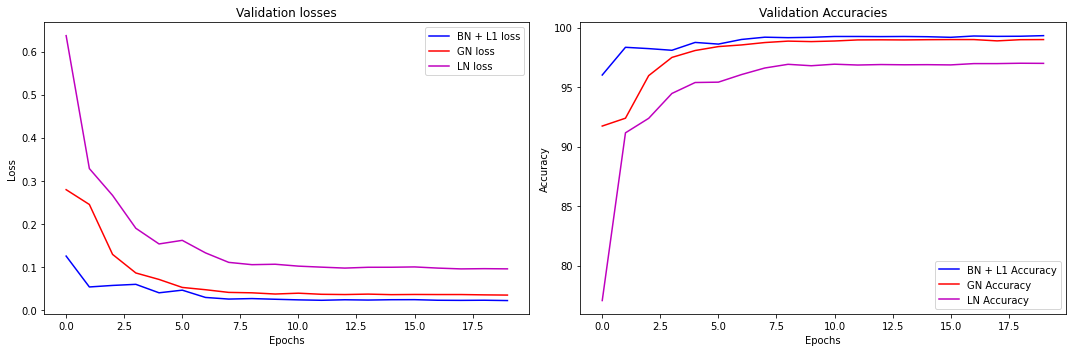

In [9]:
from mnist.visualize import plot_model_comparison

plot_model_comparison(trainers, epochs)